# SBRS LLOCV
Annual models with station based random splitting for leave location out cross validation

In [39]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from scipy.stats import gaussian_kde
import geopandas as gpd
import random
from sklearn.model_selection import KFold
from datetime import datetime
from itertools import combinations
from scipy.special import inv_boxcox

In [40]:
def LLOCV(dataframe, num_folds, station_names, model):
    """
    Function that performs leave location out cross validation on water quality time series data.
    The stations are divided into training and testing sets by referring to the unique station_name column.
    """
   
    kf = KFold(n_splits=num_folds)
    scores = []

    for train_index, test_index in kf.split(station_names):
        
        #print(f"train index: {train_index}")
        #print(f"test index: {test_index}\n")
        station_names_df = pd.DataFrame(station_names, columns=["station_names"])
        train_stations = station_names_df.iloc[train_index,:]["station_names"].values
        test_stations =  station_names_df.iloc[test_index,:]["station_names"].values

        train_df = dataframe[dataframe['station_name'].isin(train_stations)]
        test_df = dataframe[dataframe['station_name'].isin(test_stations)]

        
        # Assume the feature columns are all except 'station_name' and 'target_column'
        X_train = train_df.iloc[:,8:]
        y_train = train_df.iloc[:,1]
        X_test = test_df.iloc[:,8:]
        y_test = test_df.iloc[:,1]
        
        
        model.fit(X_train, y_train)
        
        # Test the model
        y_pred = model.predict(X_test)
        score = mean_squared_error(y_test, y_pred)
        scores.append(score)
        #print(f"Score of this fold = {r2}\n")
    rmse_scores = np.sqrt(scores)
    average_rmse = np.mean(rmse_scores)

    return average_rmse

In [41]:
with open("lambda_boxcox", 'rb') as file:
    lambda_boxcox = pickle.load(file)

In [42]:
#encode months as cyclical features

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [43]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
dataframes = {}

for i,month in enumerate(months):
    with open(f"final_df_{month}_new", 'rb') as file:
        final_df_month_new = pickle.load(file)
        final_df_month_new['month'] = i+1 
        final_df_month_new.insert(2,'month',final_df_month_new.pop('month')) # insertion index, name to insert, value to insert. pop deletes the column but also returns its value
        final_df_month_new = encode(final_df_month_new,'month',12)
    dataframes[month] = final_df_month_new

In [44]:
new_dataframes = {}
tmin = {}
tmax = {}
prec_sum = {}
i=1
for month in dataframes.keys():
    new_dataframes[month] = dataframes[month].rename(columns={f"tmin_avg_{i}": "tmin_avg", f"tmax_avg_{i}": "tmax_avg", f"prec_sum_{i}": "prec_sum" })
    i=i+1

In [45]:
merged_dfs = pd.concat(new_dataframes.values()).reset_index(drop = True)

In [46]:
def pearson_corr_coeff(X,y):
    X_bar = np.mean(X)
    y_bar = np.mean(y)
    numr = np.sum((X-X_bar)*(y-y_bar))
    denmr = np.sqrt(np.sum(np.square(X-X_bar)*np.sum(np.square(y-y_bar))))
    r = numr/denmr
    return r

In [47]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_dfs.iloc[:,8:])
scaled_df = pd.DataFrame(scaled_features, index=merged_dfs.index, columns=merged_dfs.columns[8:])
scaled_df = scaled_df.astype('float32')  # Explicitly cast to float32 if needed because the data type might not match

# Replace the original data with the scaled data
merged_dfs_scaled = merged_dfs.copy()
merged_dfs_scaled.iloc[:, 8:] = scaled_df

In [48]:
station_names = merged_dfs_scaled.station_name.unique()
unique_stations_df = merged_dfs_scaled[['station_name', 'lon', 'lat']].drop_duplicates(subset = ["station_name"])
unique_stations_df.reset_index(drop=True, inplace=True)

In [49]:
# split the stations into training and testing sets
random.seed(42)
# number of elements for each list
station_names = list(station_names)
num_elements = len(station_names)
num_80_percent = int(0.8 * num_elements)

# randomly sample 80% of the elements
list_80_percent = random.sample(station_names, num_80_percent)

# get the remaining 20% of the elements
list_20_percent = [item for item in station_names if item not in list_80_percent]


print(f"Original list length: {len(station_names)}")
print(f"80% list length: {len(list_80_percent)}")
print(f"20% list length: {len(list_20_percent)}")


Original list length: 500
80% list length: 400
20% list length: 100


In [50]:
train_df_sbrs = merged_dfs_scaled[merged_dfs_scaled["station_name"].isin(list_80_percent)]
test_df_sbrs = merged_dfs_scaled[merged_dfs_scaled["station_name"].isin(list_20_percent)]
train_df_sbrs = train_df_sbrs.sample(frac=1, random_state = 42)
test_df_sbrs = test_df_sbrs.sample(frac=1, random_state = 42)

X_train_sbrs = train_df_sbrs.iloc[:,8:]
X_test_sbrs = test_df_sbrs.iloc[:,8:]
y_train_sbrs = train_df_sbrs.iloc[:,1]
y_test_sbrs = test_df_sbrs.iloc[:,1]

y_train_sbrs_og = train_df_sbrs.iloc[:,0]
y_test_sbrs_og = test_df_sbrs.iloc[:,0]

train_indices_sbrs = X_train_sbrs.index  # indices corresponding to merged_dfs_scale
test_indices_sbrs = X_test_sbrs.index

In [51]:
# Default model

model_default_merged_sbrs = RandomForestRegressor(random_state = 42, n_jobs=30)
model_default_merged_sbrs.fit(X_train_sbrs, y_train_sbrs)
y_pred_default_merged_sbrs = model_default_merged_sbrs.predict(X_test_sbrs)
rmse_model_default_merged_sbrs = np.sqrt(mean_squared_error(y_test_sbrs_og, inv_boxcox(y_pred_default_merged_sbrs, lambda_boxcox)))
r2_model_default_merged_sbrs = r2_score(y_test_sbrs, y_pred_default_merged_sbrs)
r2_model_default_merged_sbrs_og = r2_score(y_test_sbrs_og, inv_boxcox(y_pred_default_merged_sbrs, lambda_boxcox))
r_model_default_merged_sbrs = pearson_corr_coeff(y_test_sbrs, y_pred_default_merged_sbrs)
print('RMSE [mg/L], model = default merged: ',rmse_model_default_merged_sbrs)
print('R2, model = default merged: ', r2_model_default_merged_sbrs)
print('R2 OG, model = default merged: ', r2_model_default_merged_sbrs_og)
print('R, model = default merged: ', r_model_default_merged_sbrs)

RMSE [mg/L], model = default merged:  1.4788565718127398
R2, model = default merged:  0.4451528510980183
R2 OG, model = default merged:  0.4639017314828153
R, model = default merged:  0.6865280348660375


In [53]:
y_pred_default_merged_sbrs_og = inv_boxcox(y_pred_default_merged_sbrs, lambda_boxcox)

In [54]:
# Calculate the goodness of fit for monthly subsets
# extract the datafame for just the test indices
# extract the indices where the month is equal to the given month
# extract the y_test and y_pred values at these indices and compute gof

df_test_sbrs = merged_dfs_scaled.iloc[test_indices_sbrs,:].reset_index(drop = True)  # Extract all the data in the test set dataframe and reset its index to match the indexy range of y_predict
y_test_reset_ind_sbrs_og = y_test_sbrs_og.reset_index(drop = True)    # y_test had row indices of the original dataframe. Reset index to match index of y_predict
y_test_reset_ind_sbrs = y_test_sbrs.reset_index(drop = True)
df_train_sbrs = merged_dfs_scaled.iloc[train_indices_sbrs,:].reset_index(drop = True)
# save the data in a dictionary. keys are the month names. These dicts will later be used to generate figures.
rmse_Months_default_merged_sbrs = {}
r2_Months_default_merged_sbrs_og = {}
r2_Months_default_merged_sbrs = {}
r_Months_default_merged_sbrs = {}
y_pred_Months_default_merged_sbrs = {}
y_test_Months_default_merged_sbrs = {}

y_pred_Months_default_merged_sbrs_og = {}
y_test_Months_default_merged_sbrs_og = {}


df_months_test_sbrs = {}
df_months_train_sbrs = {}

for i, month in enumerate(months):
                         
    df_test_month = df_test_sbrs.loc[df_test_sbrs['month'] == (i+1),:]   # Extract the data from test set corresponding to the given month
    df_train_month = df_train_sbrs.loc[df_train_sbrs['month'] == (i+1),:]
    df_test_month_indices = df_test_month.index                # Extract the indices from the test set that correspond to the given month
    # only calculate the error metrics for a subset of the test set. Subset based on the given month. 
    y_test_month_og = y_test_reset_ind_sbrs_og[df_test_month_indices]
    y_pred_month_og = y_pred_default_merged_sbrs_og[df_test_month_indices]

    y_test_month = y_test_reset_ind_sbrs[df_test_month_indices]
    y_pred_month = y_pred_default_merged_sbrs[df_test_month_indices]    
    
    
    rmse_month_default_merged = np.sqrt(mean_squared_error(y_test_month_og, y_pred_month_og))
    r2_month_default_merged = r2_score(y_test_month, y_pred_month)
    r2_month_default_merged_og = r2_score(y_test_month_og, y_pred_month_og)
    r_month_default_merged = pearson_corr_coeff(y_test_month, y_pred_month)

    # add data to the dictionaries
    rmse_Months_default_merged_sbrs[month] = rmse_month_default_merged
    r2_Months_default_merged_sbrs[month] = r2_month_default_merged
    r2_Months_default_merged_sbrs_og[month] = r2_month_default_merged_og
    r_Months_default_merged_sbrs[month] = r_month_default_merged
    
    y_pred_Months_default_merged_sbrs[month] = y_pred_month
    y_test_Months_default_merged_sbrs[month] = y_test_month

    y_pred_Months_default_merged_sbrs_og[month] = y_pred_month_og
    y_test_Months_default_merged_sbrs_og[month] = y_test_month_og
    
    df_months_test_sbrs[month] = df_test_month
    df_months_train_sbrs[month] = df_train_month
    # print gof metrics for each month
    print(f'RMSE default for {month} = {np.round(rmse_Months_default_merged_sbrs[month],5)}')
    print(f'R2 default for {month} = {np.round(r2_Months_default_merged_sbrs[month],5)}')
    print(f'R2 OG default for {month} = {np.round(r2_Months_default_merged_sbrs_og[month],5)}')
    print(f'R default for {month} = {np.round(r_Months_default_merged_sbrs[month], 5)}')
    print('')

RMSE default for jan = 1.62764
R2 default for jan = 0.41978
R2 OG default for jan = 0.40212
R default for jan = 0.68481

RMSE default for feb = 1.59326
R2 default for feb = 0.43192
R2 OG default for feb = 0.43459
R default for feb = 0.68851

RMSE default for mar = 1.57938
R2 default for mar = 0.44931
R2 OG default for mar = 0.44731
R default for mar = 0.70028

RMSE default for apr = 1.52501
R2 default for apr = 0.41236
R2 OG default for apr = 0.43232
R default for apr = 0.66228

RMSE default for may = 1.40712
R2 default for may = 0.45453
R2 OG default for may = 0.48369
R default for may = 0.68932

RMSE default for jun = 1.44463
R2 default for jun = 0.41005
R2 OG default for jun = 0.44348
R default for jun = 0.65889

RMSE default for jul = 1.37502
R2 default for jul = 0.3905
R2 OG default for jul = 0.44696
R default for jul = 0.64416

RMSE default for aug = 1.38617
R2 default for aug = 0.40715
R2 OG default for aug = 0.44398
R default for aug = 0.64878

RMSE default for sep = 1.49287
R2

### Optimization

In [14]:
# Optimization of model: with spatial split, using box cox transformed data

def objective_opt_sbrs_bc(trial):
    n_estimators = trial.suggest_int("n_estimators", 1, 1200)
    max_depth = trial.suggest_int("max_depth", 1, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 25)

    model_tuning = RandomForestRegressor(n_estimators =n_estimators, max_depth =max_depth, 
                                         min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, random_state = 42, n_jobs=30)
    
    mean_score = LLOCV(merged_dfs_scaled, 10, list_80_percent, model_tuning)

    return mean_score
    
    

In [15]:
study_opt_sbrs_bc =  optuna.create_study(direction = "minimize", sampler=optuna.samplers.RandomSampler(seed=42))

[I 2024-09-06 15:52:23,022] A new study created in memory with name: no-name-52fdb2f7-fbe5-43db-b0ee-788e000f1fa6


In [16]:
study_opt_sbrs_bc.optimize(objective_opt_sbrs_bc, n_trials = 500, n_jobs=1)

[I 2024-09-06 15:52:51,060] Trial 0 finished with value: 0.728851926016543 and parameters: {'n_estimators': 450, 'max_depth': 48, 'min_samples_split': 23, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.728851926016543.
[I 2024-09-06 15:53:02,322] Trial 1 finished with value: 0.7241058218901337 and parameters: {'n_estimators': 188, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 22}. Best is trial 1 with value: 0.7241058218901337.
[I 2024-09-06 15:53:42,206] Trial 2 finished with value: 0.7231776161368177 and parameters: {'n_estimators': 722, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 25}. Best is trial 2 with value: 0.7231776161368177.
[I 2024-09-06 15:54:42,706] Trial 3 finished with value: 0.7519353536203504 and parameters: {'n_estimators': 999, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.7231776161368177.
[I 2024-09-06 15:55:08,251] Trial 4 finished with value: 0.7436638772938673 and parameters:

[I 2024-09-06 16:12:18,515] Trial 36 finished with value: 0.7940602311310921 and parameters: {'n_estimators': 342, 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 13}. Best is trial 13 with value: 0.7228592341128747.
[I 2024-09-06 16:12:24,988] Trial 37 finished with value: 0.7515657830365814 and parameters: {'n_estimators': 62, 'max_depth': 14, 'min_samples_split': 28, 'min_samples_leaf': 6}. Best is trial 13 with value: 0.7228592341128747.
[I 2024-09-06 16:12:38,467] Trial 38 finished with value: 0.7449614431502304 and parameters: {'n_estimators': 174, 'max_depth': 25, 'min_samples_split': 30, 'min_samples_leaf': 7}. Best is trial 13 with value: 0.7228592341128747.
[I 2024-09-06 16:13:24,495] Trial 39 finished with value: 0.7246452485395831 and parameters: {'n_estimators': 807, 'max_depth': 39, 'min_samples_split': 8, 'min_samples_leaf': 19}. Best is trial 13 with value: 0.7228592341128747.
[I 2024-09-06 16:13:51,291] Trial 40 finished with value: 0.7300011651508627 and 

[I 2024-09-06 16:34:55,234] Trial 72 finished with value: 0.7656049614283368 and parameters: {'n_estimators': 344, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.7228592341128747.
[I 2024-09-06 16:35:53,489] Trial 73 finished with value: 0.7294364523869187 and parameters: {'n_estimators': 988, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 14}. Best is trial 13 with value: 0.7228592341128747.
[I 2024-09-06 16:36:48,707] Trial 74 finished with value: 0.7524529784299088 and parameters: {'n_estimators': 924, 'max_depth': 11, 'min_samples_split': 20, 'min_samples_leaf': 3}. Best is trial 13 with value: 0.7228592341128747.
[I 2024-09-06 16:36:54,521] Trial 75 finished with value: 0.7287763263522643 and parameters: {'n_estimators': 63, 'max_depth': 27, 'min_samples_split': 17, 'min_samples_leaf': 16}. Best is trial 13 with value: 0.7228592341128747.
[I 2024-09-06 16:37:46,538] Trial 76 finished with value: 0.739234179053313 and p

[I 2024-09-06 16:56:07,871] Trial 108 finished with value: 0.7274756796614975 and parameters: {'n_estimators': 742, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 18}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 16:56:16,922] Trial 109 finished with value: 0.759681008752595 and parameters: {'n_estimators': 88, 'max_depth': 42, 'min_samples_split': 22, 'min_samples_leaf': 3}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 16:56:26,055] Trial 110 finished with value: 0.739492191189155 and parameters: {'n_estimators': 102, 'max_depth': 50, 'min_samples_split': 12, 'min_samples_leaf': 10}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 16:57:21,731] Trial 111 finished with value: 0.724144231776548 and parameters: {'n_estimators': 976, 'max_depth': 48, 'min_samples_split': 30, 'min_samples_leaf': 19}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 16:57:42,992] Trial 112 finished with value: 0.734425034134252 an

[I 2024-09-06 17:17:53,280] Trial 144 finished with value: 0.7491624845879996 and parameters: {'n_estimators': 177, 'max_depth': 47, 'min_samples_split': 16, 'min_samples_leaf': 7}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 17:18:26,730] Trial 145 finished with value: 0.7391725971587846 and parameters: {'n_estimators': 551, 'max_depth': 50, 'min_samples_split': 16, 'min_samples_leaf': 9}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 17:19:15,807] Trial 146 finished with value: 0.7557420044214931 and parameters: {'n_estimators': 761, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 17:19:25,665] Trial 147 finished with value: 0.7274338069534366 and parameters: {'n_estimators': 154, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 17}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 17:19:41,113] Trial 148 finished with value: 0.7310309456131444 

[I 2024-09-06 17:34:50,827] Trial 180 finished with value: 0.7240480731201978 and parameters: {'n_estimators': 1127, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 19}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 17:35:29,397] Trial 181 finished with value: 0.7235080678453106 and parameters: {'n_estimators': 690, 'max_depth': 43, 'min_samples_split': 6, 'min_samples_leaf': 20}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 17:35:44,078] Trial 182 finished with value: 0.7242981481785181 and parameters: {'n_estimators': 242, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 21}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 17:36:28,366] Trial 183 finished with value: 0.7231413215776733 and parameters: {'n_estimators': 799, 'max_depth': 27, 'min_samples_split': 12, 'min_samples_leaf': 22}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 17:36:57,370] Trial 184 finished with value: 0.73625993574978

[I 2024-09-06 17:53:05,892] Trial 216 finished with value: 0.7554712978054249 and parameters: {'n_estimators': 481, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 17:54:02,384] Trial 217 finished with value: 0.7481379809361491 and parameters: {'n_estimators': 1035, 'max_depth': 48, 'min_samples_split': 12, 'min_samples_leaf': 7}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 17:54:50,658] Trial 218 finished with value: 0.7585812826023117 and parameters: {'n_estimators': 773, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 17:55:42,348] Trial 219 finished with value: 0.7524643024659432 and parameters: {'n_estimators': 860, 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 17:56:06,939] Trial 220 finished with value: 0.7621661509673263 

[I 2024-09-06 18:13:00,287] Trial 252 finished with value: 0.7231390968141326 and parameters: {'n_estimators': 300, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 25}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 18:13:40,679] Trial 253 finished with value: 0.7940307667585061 and parameters: {'n_estimators': 1133, 'max_depth': 2, 'min_samples_split': 22, 'min_samples_leaf': 24}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 18:13:57,100] Trial 254 finished with value: 0.7537130651976017 and parameters: {'n_estimators': 217, 'max_depth': 29, 'min_samples_split': 28, 'min_samples_leaf': 1}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 18:14:43,305] Trial 255 finished with value: 0.7234496181796601 and parameters: {'n_estimators': 837, 'max_depth': 15, 'min_samples_split': 28, 'min_samples_leaf': 25}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 18:15:47,757] Trial 256 finished with value: 0.7228689026803

[I 2024-09-06 18:36:41,371] Trial 288 finished with value: 0.7246206874548997 and parameters: {'n_estimators': 837, 'max_depth': 35, 'min_samples_split': 19, 'min_samples_leaf': 19}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 18:36:56,804] Trial 289 finished with value: 0.7545087464056868 and parameters: {'n_estimators': 191, 'max_depth': 45, 'min_samples_split': 27, 'min_samples_leaf': 1}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 18:37:48,485] Trial 290 finished with value: 0.7256370131738611 and parameters: {'n_estimators': 991, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 19}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 18:38:01,686] Trial 291 finished with value: 0.7304573831886315 and parameters: {'n_estimators': 193, 'max_depth': 41, 'min_samples_split': 26, 'min_samples_leaf': 13}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 18:38:03,533] Trial 292 finished with value: 0.7353373794556

[I 2024-09-06 18:55:54,072] Trial 324 finished with value: 0.7278756753354181 and parameters: {'n_estimators': 201, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 18}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 18:55:58,340] Trial 325 finished with value: 0.7348691747245644 and parameters: {'n_estimators': 38, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 14}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 18:56:47,384] Trial 326 finished with value: 0.7238657469799747 and parameters: {'n_estimators': 851, 'max_depth': 44, 'min_samples_split': 22, 'min_samples_leaf': 21}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 18:57:11,189] Trial 327 finished with value: 0.723085371283981 and parameters: {'n_estimators': 408, 'max_depth': 41, 'min_samples_split': 4, 'min_samples_leaf': 23}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 18:57:49,978] Trial 328 finished with value: 0.7260115748729842

[I 2024-09-06 19:17:51,393] Trial 360 finished with value: 0.7350907682633657 and parameters: {'n_estimators': 1164, 'max_depth': 5, 'min_samples_split': 21, 'min_samples_leaf': 12}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 19:18:48,742] Trial 361 finished with value: 0.723819936859605 and parameters: {'n_estimators': 1042, 'max_depth': 9, 'min_samples_split': 22, 'min_samples_leaf': 21}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 19:19:54,003] Trial 362 finished with value: 0.7265911248950075 and parameters: {'n_estimators': 1134, 'max_depth': 35, 'min_samples_split': 16, 'min_samples_leaf': 16}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 19:20:51,890] Trial 363 finished with value: 0.7229610693109259 and parameters: {'n_estimators': 1043, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 24}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 19:21:41,425] Trial 364 finished with value: 0.72637536548

[I 2024-09-06 19:42:55,437] Trial 396 finished with value: 0.7314844782421116 and parameters: {'n_estimators': 1186, 'max_depth': 7, 'min_samples_split': 22, 'min_samples_leaf': 11}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 19:43:24,067] Trial 397 finished with value: 0.723271768074592 and parameters: {'n_estimators': 514, 'max_depth': 36, 'min_samples_split': 22, 'min_samples_leaf': 25}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 19:43:32,749] Trial 398 finished with value: 0.7311395759403628 and parameters: {'n_estimators': 155, 'max_depth': 6, 'min_samples_split': 23, 'min_samples_leaf': 15}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 19:43:46,814] Trial 399 finished with value: 0.7385449301549885 and parameters: {'n_estimators': 329, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 23}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 19:44:03,374] Trial 400 finished with value: 0.740075814772191

[I 2024-09-06 20:01:04,350] Trial 432 finished with value: 0.7268995943715575 and parameters: {'n_estimators': 977, 'max_depth': 31, 'min_samples_split': 10, 'min_samples_leaf': 16}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 20:01:40,587] Trial 433 finished with value: 0.7232355832032467 and parameters: {'n_estimators': 633, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 23}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 20:02:13,048] Trial 434 finished with value: 0.7322336732425688 and parameters: {'n_estimators': 540, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 11}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 20:03:13,540] Trial 435 finished with value: 0.7554442575213963 and parameters: {'n_estimators': 994, 'max_depth': 37, 'min_samples_split': 24, 'min_samples_leaf': 1}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 20:03:46,742] Trial 436 finished with value: 0.7475255707017

[I 2024-09-06 20:23:36,432] Trial 468 finished with value: 0.729602686009455 and parameters: {'n_estimators': 608, 'max_depth': 43, 'min_samples_split': 23, 'min_samples_leaf': 14}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 20:24:18,981] Trial 469 finished with value: 0.7280880255259198 and parameters: {'n_estimators': 709, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 15}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 20:25:05,807] Trial 470 finished with value: 0.7240335345356456 and parameters: {'n_estimators': 827, 'max_depth': 44, 'min_samples_split': 20, 'min_samples_leaf': 20}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 20:25:21,172] Trial 471 finished with value: 0.7475407298156802 and parameters: {'n_estimators': 193, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 91 with value: 0.7227245420922066.
[I 2024-09-06 20:26:11,785] Trial 472 finished with value: 0.73380220911091

In [17]:
study_opt_sbrs_bc.best_params

{'n_estimators': 1130,
 'max_depth': 20,
 'min_samples_split': 29,
 'min_samples_leaf': 23}

In [19]:
best_params_SBRS = study_opt_sbrs_bc.best_params

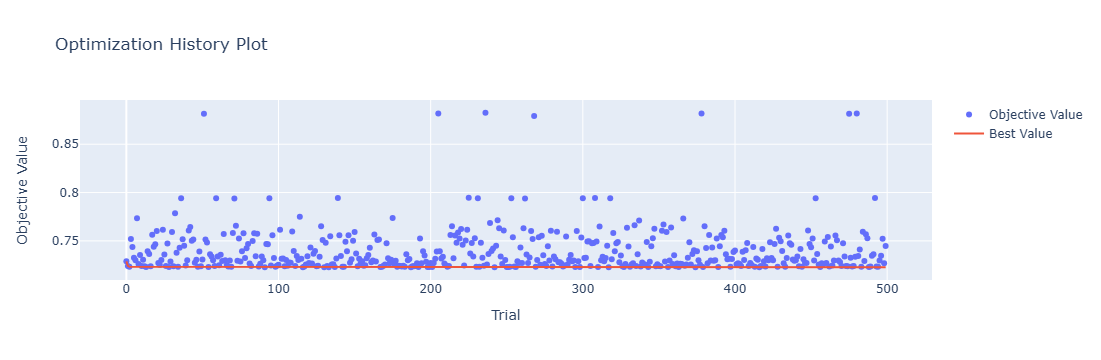

In [20]:
optuna.visualization.plot_optimization_history(study_opt_sbrs_bc)

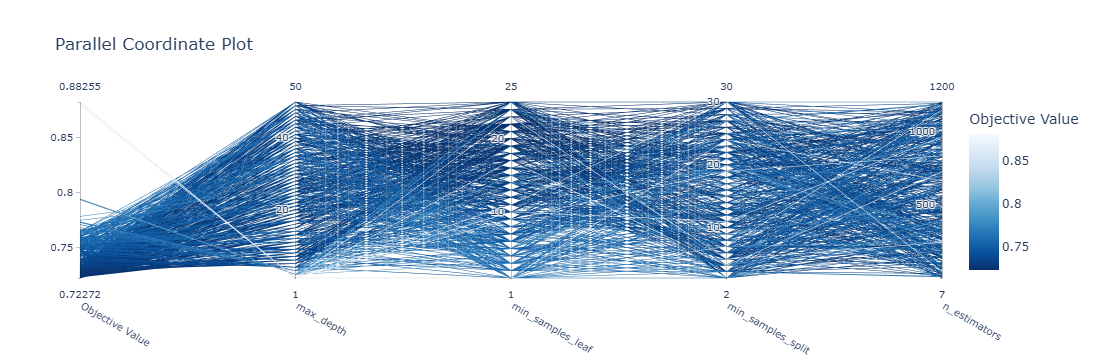

In [21]:
optuna.visualization.plot_parallel_coordinate(study_opt_sbrs_bc)

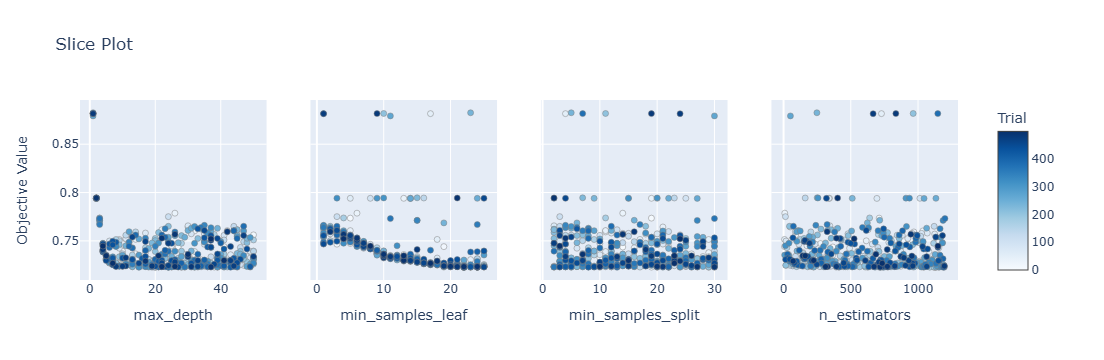

In [22]:
optuna.visualization.plot_slice(study_opt_sbrs_bc, params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf' ])

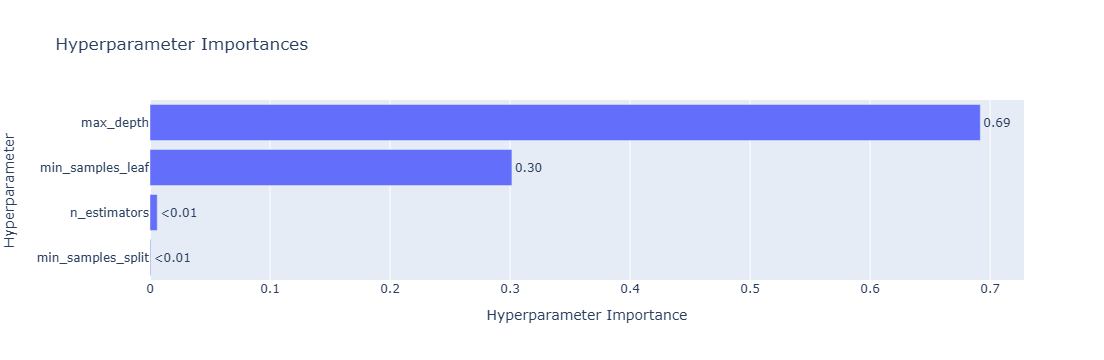

In [23]:
optuna.visualization.plot_param_importances(study_opt_sbrs_bc)

In [24]:
with open('study_opt_sbrs_bc', 'wb') as file:
         pickle.dump(study_opt_sbrs_bc, file)

In [25]:
with open('SBRS_llocv_best_params', 'wb') as file:
         pickle.dump(best_params_SBRS, file)

In [26]:
# with open("SBRS_llocv_best_params","rb") as file:
#     best_params_SBRS = pickle.load(file)

In [28]:
# Train and Test the best model

best_n_estimators_opt_merged_sbrs = best_params_SBRS['n_estimators']
best_max_depth_opt_merged_sbrs = best_params_SBRS['max_depth']
best_min_samples_split_opt_merged_sbrs = best_params_SBRS['min_samples_split']
best_min_samples_leaf_opt_merged_sbrs = best_params_SBRS['min_samples_leaf']

best_model_opt_merged_sbrs = RandomForestRegressor(n_estimators = best_n_estimators_opt_merged_sbrs, max_depth = best_max_depth_opt_merged_sbrs , 
                                              min_samples_split= best_min_samples_split_opt_merged_sbrs, 
                                              min_samples_leaf=best_min_samples_leaf_opt_merged_sbrs, random_state=42, n_jobs = 3)

best_model_opt_merged_sbrs.fit(X_train_sbrs, y_train_sbrs)

y_pred_opt_merged_sbrs = best_model_opt_merged_sbrs.predict(X_test_sbrs)

rmse_model_opt_merged_sbrs = np.sqrt(mean_squared_error(y_test_sbrs_og, inv_boxcox(y_pred_opt_merged_sbrs, lambda_boxcox)))
r2_model_opt_merged_sbrs = r2_score(y_test_sbrs, y_pred_opt_merged_sbrs)
r2_model_opt_merged_sbrs_og = r2_score(y_test_sbrs_og, inv_boxcox(y_pred_opt_merged_sbrs, lambda_boxcox))
r_model_opt_merged_sbrs = pearson_corr_coeff(y_test_sbrs, y_pred_opt_merged_sbrs)

print('RMSE [mg/L], model = opt merged _sbrs: ',rmse_model_opt_merged_sbrs)
print('R2, model = opt merged _sbrs: ', r2_model_opt_merged_sbrs)
print('R2 OG, model = opt merged _sbrs: ', r2_model_opt_merged_sbrs_og)
print('R, model = opt merged _sbrs: ', r_model_opt_merged_sbrs)

RMSE [mg/L], model = opt merged _sbrs:  1.467392327889841
R2, model = opt merged _sbrs:  0.47469208672610674
R2 OG, model = opt merged _sbrs:  0.47218128932564407
R, model = opt merged _sbrs:  0.6936519737626425


In [29]:
y_pred_opt_merged_sbrs

array([ 1.3017873 ,  1.42766432,  0.01722144, ...,  0.60026247,
       -0.15580386,  1.76067884])

In [30]:
y_pred_opt_merged_sbrs_og = inv_boxcox(y_pred_opt_merged_sbrs, lambda_boxcox)

In [31]:
# Calculate the goodness of fit for monthly subsets
# extract the datafame for just the test indices
# extract the indices where the month is equal to the given month
# extract the y_test and y_pred values at these indices and compute gof

df_test_sbrs = merged_dfs_scaled.iloc[test_indices_sbrs,:].reset_index(drop = True)  # Extract all the data in the test set dataframe and reset its index to match the indexy range of y_predict
y_test_reset_ind_sbrs_og = y_test_sbrs_og.reset_index(drop = True)    # y_test had row indices of the original dataframe. Reset index to match index of y_predict
y_test_reset_ind_sbrs = y_test_sbrs.reset_index(drop = True)
df_train_sbrs = merged_dfs_scaled.iloc[train_indices_sbrs,:].reset_index(drop = True)
# save the data in a dictionary. keys are the month names. These dicts will later be used to generate figures.
rmse_Months_opt_merged_sbrs = {}
r2_Months_opt_merged_sbrs_og = {}
r2_Months_opt_merged_sbrs = {}
r_Months_opt_merged_sbrs = {}
y_pred_Months_opt_merged_sbrs = {}
y_test_Months_opt_merged_sbrs = {}

y_pred_Months_opt_merged_sbrs_og = {}
y_test_Months_opt_merged_sbrs_og = {}


df_months_test_sbrs = {}
df_months_train_sbrs = {}

for i, month in enumerate(months):
                         
    df_test_month = df_test_sbrs.loc[df_test_sbrs['month'] == (i+1),:]   # Extract the data from test set corresponding to the given month
    df_train_month = df_train_sbrs.loc[df_train_sbrs['month'] == (i+1),:]
    df_test_month_indices = df_test_month.index                # Extract the indices from the test set that correspond to the given month
    # only calculate the error metrics for a subset of the test set. Subset based on the given month. 
    y_test_month_og = y_test_reset_ind_sbrs_og[df_test_month_indices]
    y_pred_month_og = y_pred_opt_merged_sbrs_og[df_test_month_indices]

    y_test_month = y_test_reset_ind_sbrs[df_test_month_indices]
    y_pred_month = y_pred_opt_merged_sbrs[df_test_month_indices]    
    
    
    rmse_month_opt_merged = np.sqrt(mean_squared_error(y_test_month_og, y_pred_month_og))
    r2_month_opt_merged = r2_score(y_test_month, y_pred_month)
    r2_month_opt_merged_og = r2_score(y_test_month_og, y_pred_month_og)
    r_month_opt_merged = pearson_corr_coeff(y_test_month, y_pred_month)

    # add data to the dictionaries
    rmse_Months_opt_merged_sbrs[month] = rmse_month_opt_merged
    r2_Months_opt_merged_sbrs[month] = r2_month_opt_merged
    r2_Months_opt_merged_sbrs_og[month] = r2_month_opt_merged_og
    r_Months_opt_merged_sbrs[month] = r_month_opt_merged
    
    y_pred_Months_opt_merged_sbrs[month] = y_pred_month
    y_test_Months_opt_merged_sbrs[month] = y_test_month

    y_pred_Months_opt_merged_sbrs_og[month] = y_pred_month_og
    y_test_Months_opt_merged_sbrs_og[month] = y_test_month_og
    
    df_months_test_sbrs[month] = df_test_month
    df_months_train_sbrs[month] = df_train_month
    # print gof metrics for each month
    print(f'RMSE opt for {month} = {np.round(rmse_Months_opt_merged_sbrs[month],5)}')
    print(f'R2 opt for {month} = {np.round(r2_Months_opt_merged_sbrs[month],5)}')
    print(f'R2 OG opt for {month} = {np.round(r2_Months_opt_merged_sbrs_og[month],5)}')
    print(f'R opt for {month} = {np.round(r_Months_opt_merged_sbrs[month], 5)}')
    print('')

RMSE opt for jan = 1.61163
R2 opt for jan = 0.4701
R2 OG opt for jan = 0.41382
R opt for jan = 0.71884

RMSE opt for feb = 1.58865
R2 opt for feb = 0.47374
R2 OG opt for feb = 0.43786
R opt for feb = 0.72025

RMSE opt for mar = 1.53859
R2 opt for mar = 0.51667
R2 OG opt for mar = 0.47549
R opt for mar = 0.7342

RMSE opt for apr = 1.52113
R2 opt for apr = 0.43617
R2 OG opt for apr = 0.43521
R opt for apr = 0.66757

RMSE opt for may = 1.4264
R2 opt for may = 0.46105
R2 OG opt for may = 0.46944
R opt for may = 0.68408

RMSE opt for jun = 1.38861
R2 opt for jun = 0.47532
R2 OG opt for jun = 0.48581
R opt for jun = 0.69264

RMSE opt for jul = 1.38906
R2 opt for jul = 0.39119
R2 OG opt for jul = 0.43561
R opt for jul = 0.64365

RMSE opt for aug = 1.41793
R2 opt for aug = 0.37206
R2 OG opt for aug = 0.41821
R opt for aug = 0.63494

RMSE opt for sep = 1.50163
R2 opt for sep = 0.39044
R2 OG opt for sep = 0.39933
R opt for sep = 0.63726

RMSE opt for oct = 1.38798
R2 opt for oct = 0.42523
R2 OG 

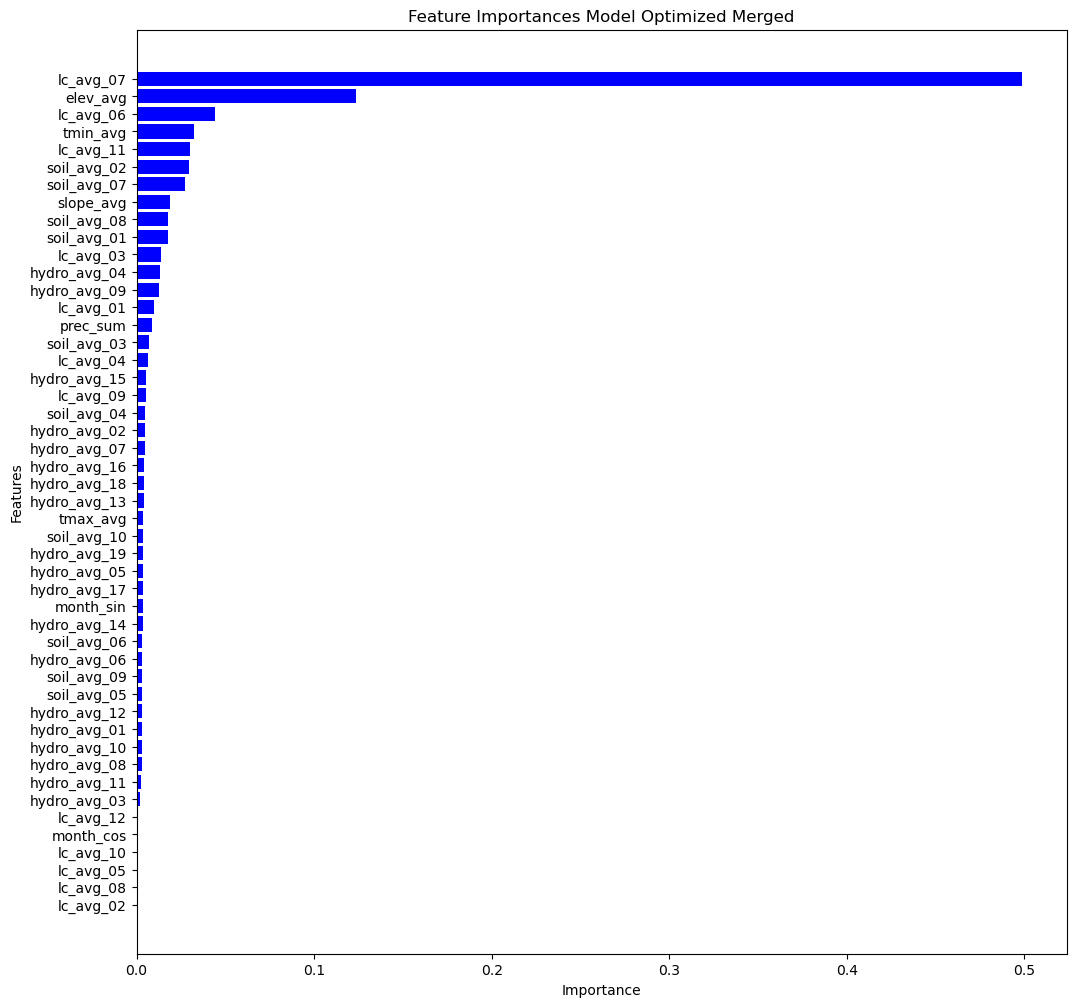

In [32]:
# Less features

feature_importances_sbrs = best_model_opt_merged_sbrs.feature_importances_

indices = np.argsort(feature_importances_sbrs)

# Prepare the figure
plt.figure(figsize=(12, 12))
plt.title('Feature Importances Model Optimized Merged')

# Create horizontal bars
plt.barh(range(len(indices)), feature_importances_sbrs[indices], color='b', align='center')

# Add feature names as y-tick labels
plt.yticks(range(len(indices)), [merged_dfs.columns[8:][i] for i in indices])

# Label the axes
plt.xlabel('Importance')
plt.ylabel('Features')
#plt.savefig('feature_importance_opt_merged.jpg', format = 'jpg', bbox_inches = 'tight')
# Show the plot
plt.show()

In [33]:
features_filtered = [merged_dfs_scaled.iloc[:,8:].columns[i] for i in range(len(feature_importances_sbrs)) if feature_importances_sbrs[i] > 0.01 ]

In [34]:
features_filtered

['slope_avg',
 'elev_avg',
 'lc_avg_03',
 'lc_avg_06',
 'lc_avg_07',
 'lc_avg_11',
 'hydro_avg_04',
 'hydro_avg_09',
 'soil_avg_01',
 'soil_avg_02',
 'soil_avg_07',
 'soil_avg_08',
 'tmin_avg']

In [64]:
vars2save = [merged_dfs, merged_dfs_scaled,
             list_80_percent, list_20_percent,
             X_train_sbrs,
             X_test_sbrs,
             y_train_sbrs,
             y_test_sbrs,
             y_train_sbrs_og,
             y_test_sbrs_og,
             train_indices_sbrs,
             test_indices_sbrs,
             y_pred_default_merged_sbrs,
             y_pred_opt_merged_sbrs,
             feature_importances_sbrs,
             rmse_model_default_merged_sbrs,
             r2_model_default_merged_sbrs,
             r2_model_default_merged_sbrs_og,
             rmse_model_opt_merged_sbrs,
             r2_model_opt_merged_sbrs,
             r2_model_opt_merged_sbrs_og,
             rmse_Months_opt_merged_sbrs,
             r2_Months_opt_merged_sbrs]

vars_name = ['merged_dfs_sbrs', 'merged_dfs_scaled_sbrs',
             'list_80_percent_sbrs', 'list_20_percent_sbrs',
             'X_train_sbrs',
             'X_test_sbrs',
             'y_train_sbrs',
             'y_test_sbrs',
             'y_train_sbrs_og',
             'y_test_sbrs_og',
             'train_indices_sbrs',
             'test_indices_sbrs',
             'y_pred_default_merged_sbrs',
             'y_pred_opt_merged_sbrs',
             'feature_importances_sbrs',
             'rmse_model_default_merged_sbrs',
             'r2_model_default_merged_sbrs',
             'r2_model_default_merged_sbrs_og',
             'rmse_model_opt_merged_sbrs',
             'r2_model_opt_merged_sbrs',
             'r2_model_opt_merged_sbrs_og',
             'rmse_Months_opt_merged_sbrs',
             'r2_Months_opt_merged_sbrs'] 


In [65]:
for i in range(len(vars2save)):
    # save the variables
    filepath = vars_name[i]
    with open(filepath, 'wb') as file:
        pickle.dump(vars2save[i], file)